In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from inv_set.jet import diff_game
from controllers.constant import target
from envs.MooreGreitzerJet import jet

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
def verify_unsafe(env, num_states, num_traj, num_steps):
    # return states that have some unsafe input trajectory
    init_states = env.sample_states(num_states)
    safe = np.full(init_states.shape[0], True)
    for i in range(num_traj):
        states = init_states.copy()
        for j in range(num_steps):
            inputs = env.sample_inputs(init_states, 1) * 0
            dists = env.sample_dists(init_states)
            states = env.next_states(states, inputs, dists).reshape(-1, 2)
            vals = env.inv_set.forward(states)
            safe[vals > 0] = False
    return init_states[safe], init_states[np.logical_not(safe)]

In [6]:
def verify_safe(env, num_states, num_traj, num_steps):
    # return states that have some safe input trajectory
    init_states = env.sample_states(num_states)
    safe_global = np.full(init_states.shape[0], False)
    for i in range(num_traj):
        safe_local = np.full(init_states.shape[0], True)
        states = init_states.copy()
        for j in range(num_steps):
            inputs = env.sample_inputs(init_states, 1)
            dists = env.sample_dists(init_states)
            states = env.next_states(states, inputs, dists).reshape(-1, 2)
            vals = env.inv_set.forward(states)
            safe_local = np.logical_and(safe_local, vals <= 0)
        safe_global = np.logical_or(safe_global, safe_local)
    return init_states[safe_global], init_states[np.logical_not(safe_global)]

In [10]:
grid_xlow = -0.51
grid_xhigh = 0.51
grid_ylow = -0.51
grid_yhigh = 0.51
num_points = 400
path_to_diff_game = 'inv_set/jet_is_ser.pkl'
inv_set = diff_game(path_to_diff_game, grid_xlow, grid_xhigh, grid_ylow, grid_yhigh, num_points)

# initialize system
u_max = 0.01
d_max = 0.02
sys_dt = 0.01
disc_dt = 0.1

env = jet(u_max, d_max, sys_dt, disc_dt, inv_set)

In [8]:
num_states = 10000
num_traj = 1000
num_steps = 200

safe, unsafe = verify_unsafe(env, num_states, num_traj, num_steps)

In [5]:
# plot safe
plt.scatter(safe[:, 0], safe[:, 1], s=0.1, label='no unsafe trajectory')

# plot unsafe
plt.scatter(unsafe[:, 0], unsafe[:, 1], s=1, label='unsafe trajectory exists')


x_grid = np.linspace(grid_xlow, grid_xhigh, num_points)
y_grid = np.linspace(grid_ylow, grid_yhigh, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
plt.contour(X, Y, inv_set.value.T, levels=[0], colors='black', linestyles='dashed')

plt.title("(u=uniform, dist=uniform sample)")

print(len(unsafe))
plt.show()

NameError: name 'safe' is not defined

In [24]:
states = env.sample_states(10000)
next_states = states.copy()

In [11]:
for _ in range(10000):
    inputs = env.sample_inputs(states, 1)
    dists = env.sample_dists(states)
    next_states = env.next_states(next_states, inputs, dists).reshape(-1, 2)

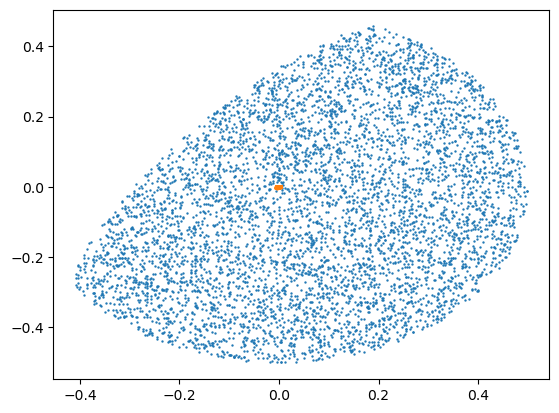

In [12]:
plt.scatter(states[:, 0], states[:, 1], s=0.5)
plt.scatter(next_states[:, 0], next_states[:, 1], s=0.5)
plt.show()

In [48]:
print(env.inv_set.forward(states).max())

-1.7298286481958994e-05


In [3]:
def bang(x, t):
    return np.array([0])

ref = target(bang)

t = 10

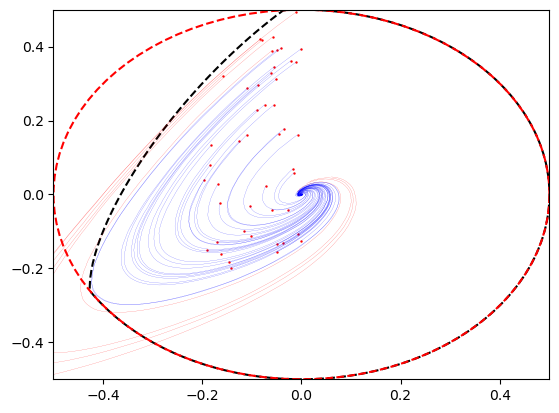

In [11]:
x_grid = np.linspace(grid_xlow, grid_xhigh, num_points)
y_grid = np.linspace(grid_ylow, grid_yhigh, num_points)
X, Y = np.meshgrid(x_grid, y_grid)

plt.contour(X, Y, inv_set.value.T, levels=[0], colors='black', linestyles='dashed')

theta = np.linspace(0, 2 * np.pi, 100)  # Angle values
r = 0.5  # Radius of the circle
x = r * np.cos(theta)  # x-coordinates
y = r * np.sin(theta)  # y-coordinates

plt.plot(x, y, 'r--')
states = env.sample_states(50)
for state in states:
    traj, u_hist, h_hist = env.run_system(state, t, ref)
    if np.any(h_hist > 0):
        plt.plot(traj[:, 0], traj[:, 1], c='red', linewidth=0.1)
    else:
        plt.plot(traj[:, 0], traj[:, 1], c='blue', linewidth=0.1)
    plt.scatter(state[0], state[1], c='r', s=0.5)

    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
plt.show()